In [50]:
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [51]:
import pandas as pd

In [52]:
import numpy as np

In [53]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [54]:
import torch
from sentence_transformers import SentenceTransformer
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Model is loaded on:", model.device)

/Users/bensmus/Desktop/Projects/AG_news_classify/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model is loaded on: mps:0


In [55]:
filename = 'AG_news_dataset/train.csv'
df = pd.read_csv(filename)
descriptions = np.array(df['Description'])
categories = np.array(df['Class Index'] - 1) # This -1 is CRUCIAL because classes must be 0...N-1 where N is number of classes.
descriptions, categories = shuffle(descriptions, categories, random_state=0)


In [56]:
embeddings = model.encode(descriptions)

In [8]:
# pca = PCA(n_components=50)
# embeddings = pca.fit_transform(embeddings)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(embeddings, categories, test_size=0.2, random_state=42)

In [159]:
inputs = tf.keras.Input(shape=(384,))
x = layers.Dense(200, activation='relu')(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)     │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 200)            │        77,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,354 (399.82 KB)

 Trainable params: 102,354 (399.82 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [161]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5338 - loss: 1.0701 - val_accuracy: 0.8816 - val_loss: 0.3602
Epoch 2/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8566 - loss: 0.4588 - val_accuracy: 0.8870 - val_loss: 0.3367
Epoch 3/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8738 - loss: 0.4127 - val_accuracy: 0.8909 - val_loss: 0.3242
Epoch 4/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8820 - loss: 0.3856 - val_accuracy: 0.8926 - val_loss: 0.3177
Epoch 5/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8825 - loss: 0.3814 - val_accuracy: 0.8943 - val_loss: 0.3108
Epoch 6/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8848 - loss: 0.3703 - val_accuracy: 0.8958 - val_loss: 0.3063
Epoch 7/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8891 - loss: 0.3577 - val_accuracy: 0.8966 - val_loss: 0.3021
Epoch 8/100
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8886 - loss: 0

In [162]:
y_val_predict_probs = model.predict(X_val)

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


In [163]:
y_val_predict = np.argmax(y_val_predict_probs, axis=1)

In [164]:
print('val accuracy', sum(y_val_predict == y_val) / len(y_val))

val accuracy 0.914


In [165]:
val_accuracy = history.history['val_accuracy']

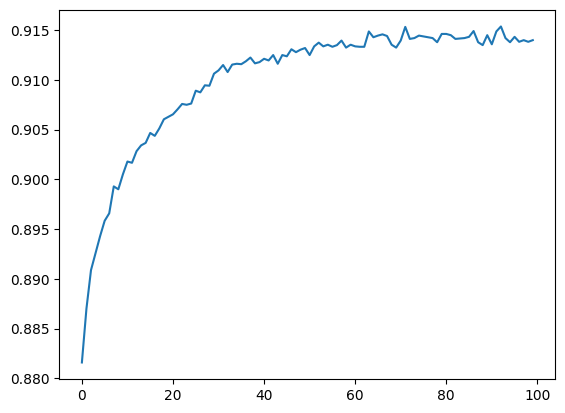

In [166]:
import  matplotlib.pyplot as plt
plt.plot(val_accuracy)